In [149]:
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

In [109]:
# load data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

print("Shape: {}".format(df_train.shape))
# remove constant columns
remove = []
for col in df_train.columns:
    if df_train[col].std() == 0:
        remove.append(col)
        
df_train.drop(remove, axis=1, inplace=True)
df_test.drop(remove, axis=1, inplace=True)

print("Removed {} constant columns".format(len(remove)))

# remove duplicated columns
remove = []
c = df_train.columns
for i in range(len(c)-1):
    v = df_train[c[i]].values
    for j in range(i+1,len(c)):
        if np.array_equal(v,df_train[c[j]].values):
            remove.append(c[j])
            
print("Removed {} duplicate columns".format(len(remove)))

df_train.drop(remove, axis=1, inplace=True)
df_test.drop(remove, axis=1, inplace=True)

Shape: (76020, 371)
Removed 34 constant columns
Removed 29 duplicate columns


## Number of values per feature

For categorical variables, if one category takes more than 95% of the observations, theres is nothing to learn from it.

In [110]:
remove = []
for col in df_train.columns:
    if col != 'TARGET':
        nb = len(df_train[col].unique())
        if nb <= 12:
            df_train[col] = df_train[col].map("CAT_{}".format)
            df_train[col] = df_train[col].astype('category')
            freq = df_train[col].value_counts()/len(df_train)
            if (freq > 0.95).any():
                remove.append(col)
                
df_train.drop(remove, axis=1, inplace=True)
df_test.drop(remove, axis=1, inplace=True)

print("Removed {} categorical columns".format(len(remove)))

Removed 150 categorical columns


In [111]:
print("Shape: {}".format(df_train.shape))

Shape: (76020, 158)


In [150]:
base_vars = df_train.columns[df_train.columns.str.startswith('var') | df_train.columns.str.startswith('num_var')]
print(base_vars)


Index([u'var3', u'var15', u'num_var4', u'num_var5', u'num_var12_0',
       u'num_var13_0', u'num_var13', u'num_var30_0', u'num_var30',
       u'num_var35', u'num_var37_med_ult2', u'num_var37_0', u'num_var39_0',
       u'num_var41_0', u'num_var42_0', u'num_var42', u'var36', u'var21',
       u'num_var22_hace2', u'num_var22_hace3', u'num_var22_ult1',
       u'num_var22_ult3', u'num_var43_emit_ult1', u'num_var43_recib_ult1',
       u'num_var45_hace2', u'num_var45_hace3', u'num_var45_ult1',
       u'num_var45_ult3', u'var38'],
      dtype='object')


In [151]:
df_train = df_train.replace(-999999,2)

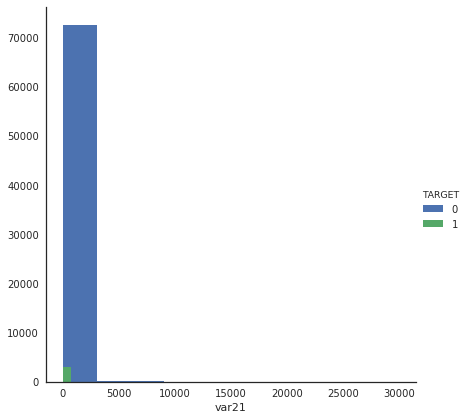

In [167]:
sns.FacetGrid(df_train, hue="TARGET", size=6)\
    .map(plt.hist, "var21")\
    .add_legend()
    
plt.show()

## Feature correlation

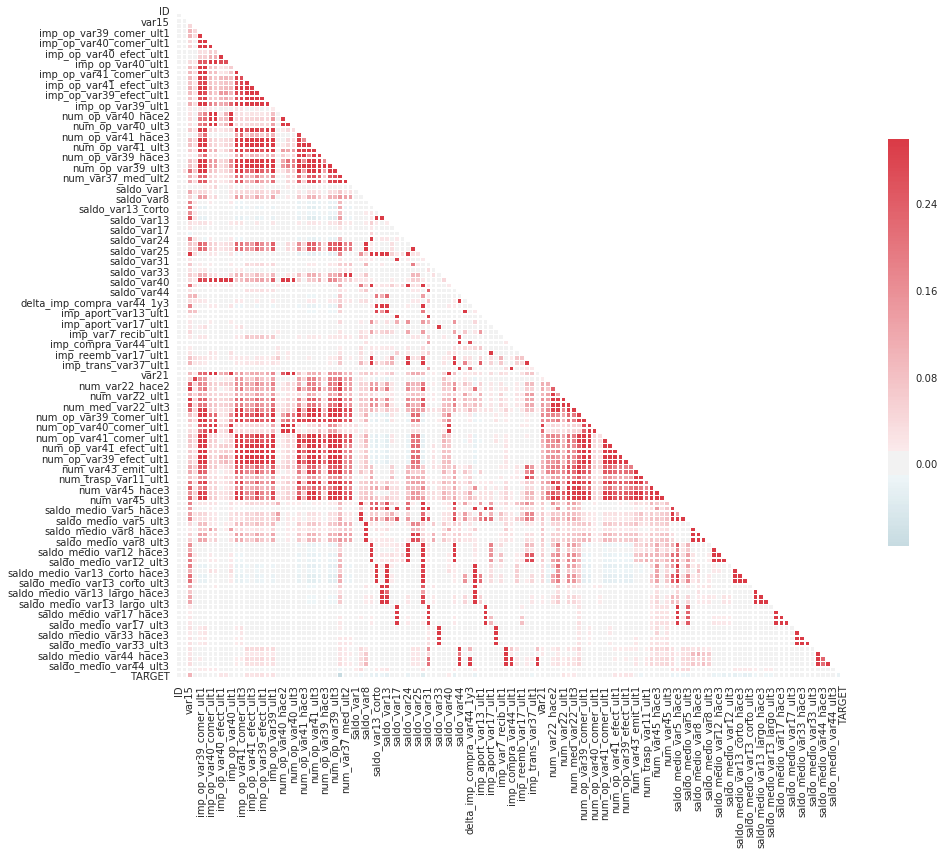

In [92]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = df_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [93]:
df_train.to_csv('train2.csv', index=False)
df_test.to_csv('test2.csv', index=False)

# importing the MLBox

In [94]:
from mlbox.preprocessing import *
from mlbox.optimisation import *
from mlbox.prediction import *

In [95]:
paths = ["train2.csv","test2.csv"]
target_name = "TARGET"

# reading and cleaning all files 

In [96]:
rd = Reader(sep = ',', to_hdf5=True)
df = rd.train_test_split(paths, target_name)


reading csv : train2.csv ...
cleaning data ...
CPU time: 6.59106421471 seconds

reading csv : test2.csv ...
cleaning data ...
CPU time: 5.72641301155 seconds

> Number of common features : 157

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 29
> Number of numerical features: 128
> Number of training samples : 76020
> Number of test samples : 75818

> You have no missing values on train set...

> Task : classification
0.0    73012
1.0     3008
Name: TARGET, dtype: int64

encoding target ...

dumping files into directory : save
train dumped
test dumped
CPU time: 0.704627990723 seconds


In [97]:
ids = df['test']['ID']

df['train'] = df['train'].drop('ID', axis = 1)
df['test'] = df['test'].drop('ID', axis = 1)



In [98]:
df['train']['var38'] = np.log(df['train']['var38'])
df['test']['var38'] = np.log(df['test']['var38'])

df['train']['saldo_var30'] = np.log(1+df['train']['saldo_var30'])
df['test']['saldo_var30'] = np.log(1+df['test']['saldo_var30'])


In [48]:
dft = Drift_thresholder()
df = dft.fit_transform(df)


computing drifts ...
CPU time: 35.571901083 seconds

> Top 10 drifts

('num_var30', 0.0066842386906835749)
('num_meses_var5_ult3', 0.0054425745826236493)
('num_var22_ult3', 0.0039540746120940717)
('num_op_var41_hace2', 0.0037193133178445859)
('ind_var5', 0.0035437995428329039)
('ind_var30', 0.0034204329676374989)
('num_med_var22_ult3', 0.0032546692060702043)
('var38', 0.0028759305618883957)
('num_var43_recib_ult1', 0.0028524403789520481)
('imp_op_var41_efect_ult3', 0.0027300041114672879)

> Deleted variables : []
> Drift coefficients dumped into directory : save


## Grid Search

In [ ]:
space_xgb={
    'est__strategy'             :{"search":"choice",
                                  "space":["XGBoost"]},
    'est__max_depth'            :{"search":"choice",
                                  "space":[3,5,7]},
    'est__learning_rate'        :{"search":"uniform",
                                  "space":[0.01,0.1]},
    'est__reg_alpha'            :{"search":"uniform",
                                  "space":[0,10]},
    'est__reg_lambda'           :{"search":"uniform",
                                  "space":[0,10]}
    }

best = opt.optimise(space_xgb, df)

In [101]:
best = {
    'ne__numerical_strategy' :'mean',
    'ce__strategy' : 'label_encoding',
    'est__reg_alpha': 5.539648082599189, 
    'est__colsample_bytree': 0.8, 
    'est__learning_rate': 0.024956106633922004, 
    'est__nthread': 4, 
    'est__base_score': 0.5, 
    'est__strategy': 'XGBoost', 
    'est__n_estimators': 250, 
    'est__subsample': 0.9, 
    'est__reg_lambda': 3.6787856456648504,
    'est__objective': 'binary:logistic', 
    'est__max_depth': 5,
    'est__missing': 9999999999
}

In [102]:
opt = Optimiser(scoring = 'roc_auc', n_folds = 3)
opt.evaluate(best, df)


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'entity_embedding'}

>>> ESTIMATOR :{'reg_alpha': 5.539648082599189, 'colsample_bytree': 0.8, 'silent': True, 'missing': 9999999999, 'scale_pos_weight': 1, 'learning_rate': 0.024956106633922004, 'colsample_bylevel': 1.0, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'strategy': 'XGBoost', 'n_estimators': 250, 'subsample': 0.9, 'reg_lambda': 3.6787856456648504, 'seed': 0, 'min_child_weight': 1, 'objective': 'binary:logistic', 'max_depth': 5, 'gamma': 0}


MEAN SCORE : roc_auc = 0.839871936523
VARIANCE : 0.00196956933883 (fold 1 = 0.837642395764, fold 2 = 0.839540793325, fold 3 = 0.84243262048)
CPU time: 463.926153183 seconds



0.83987193652311587


fitting the pipeline ...
CPU time: 216.244297981 seconds


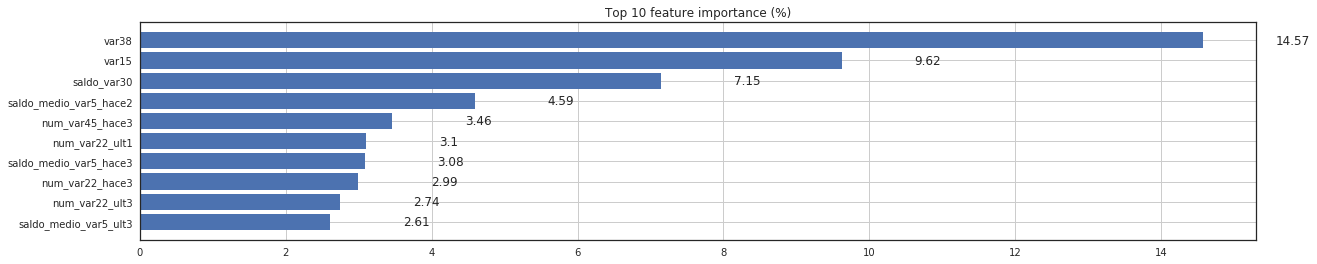


> Feature importances dumped into directory : save

predicting ...
CPU time: 32.9414510727 seconds

> Overview on predictions : 

        0.0       1.0  TARGET_predicted
0  0.960957  0.039043                 0
1  0.950437  0.049563                 0
2  0.994835  0.005165                 0
3  0.988204  0.011796                 0
4  0.994592  0.005408                 0
5  0.871801  0.128199                 0
6  0.941419  0.058581                 0
7  0.861258  0.138742                 0
8  0.974040  0.025960                 0
9  0.978774  0.021226                 0

dumping predictions into directory : save ...


<mlbox.prediction.predictor.Predictor instance at 0x7fca765c8b00>

In [103]:
prd = Predictor()
prd.fit_predict(best, df)

In [104]:

preds = pd.read_csv('save/TARGET_predictions.csv')

output = pd.DataFrame({
    'ID' : ids.astype('int32'),
    'TARGET' : preds['1.0']})

output.head()

,ID,TARGET
0,2,0.039043
1,5,0.049563
2,6,0.005165
3,7,0.011796
4,9,0.005408


In [105]:
output.to_csv('submission.csv', index=False)

## Focus on important variables

In [20]:
target = df_train.TARGET

In [21]:
var38 = df_train.var38

/home/francois/anaconda2/envs/mlbox/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


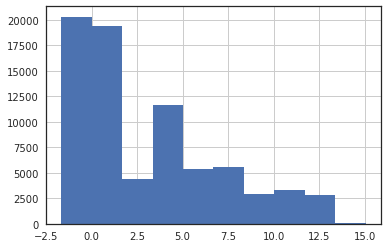

In [12]:
%matplotlib inline
np.log(1+df_train.saldo_var30).hist()

In [31]:
from sklearn import tree
import graphviz

tmp_df = pd.DataFrame({'var15':df_train.var15, 
                       'var38_log':np.log(df_train.var38),
                       'saldo_var30':df_train.saldo_var30,
                       'TARGET':target})

clf = tree.DecisionTreeClassifier()
clf = clf.fit(tmp_df.var15.values.reshape(-1, 1), tmp_df.TARGET.values.reshape(-1, 1))

dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("var15") 

clf = tree.DecisionTreeClassifier(max_depth= 10, min_samples_leaf=100)
clf = clf.fit(tmp_df.var38_log.values.reshape(-1, 1), tmp_df.TARGET.values.reshape(-1, 1))

dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("var38_log") 

'var38_log.pdf'

In [33]:
clf = tree.DecisionTreeClassifier(max_depth= 10, min_samples_leaf=100)
clf = clf.fit(X=tmp_df.drop('TARGET', axis=1),  y  = tmp_df.TARGET)
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("top3_variables") 

'top3_variables.pdf'